In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

%matplotlib inline
seed_set = 311  # Just my BD
np.random.seed(seed_set)

# Plotting libs
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
AVG_EARTH_RADIUS = 6371  # in km


def haversine(point1, point2, miles=False):
    """ Calculate the great-circle distance between two points on the Earth surface.
    :input: two 2-tuples, containing the latitude and longitude of each point
    in decimal degrees.
    Example: haversine((45.7597, 4.8422), (48.8567, 2.3508))
    :output: Returns the distance bewteen the two points.
    The default unit is kilometers. Miles can be returned
    if the ``miles`` parameter is set to True.
    """

    # Unpack latitude/longitude
    lat1, lng1 = point1
    lat2, lng2 = point2

    # Convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))

    # Calculate haversine
    lat, lng= lat2 - lat1, lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h * 0.621371 if miles else h # in m/km


def dummy_manhattan_distance(point1, point2):
    lat1, lng1 = point1
    lat2, lng2 = point2
    a = haversine((lat1, lng1), (lat1, lng2))
    b = haversine((lat1, lng1), (lat2, lng1))

    return haversine((lat1, lng1), (lat1, lng2)) + haversine((lat1, lng1), (lat2, lng1))


def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    (lat1, lng1, lat2, lng2) = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    
    return np.degrees(np.arctan2(y, x))


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
train.head(2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


In [5]:
test.head(2)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N


## Original Features

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds

## Build Features

In [6]:
# Build features based on longitutde/latitude
train['distance_haversine'] = haversine(
    (train['pickup_latitude'].values, train['pickup_longitude'].values),
    (train['dropoff_latitude'].values, train['dropoff_longitude'].values)
)
train['distance_dummy_manhattan'] = dummy_manhattan_distance(
    (train['pickup_latitude'].values, train['pickup_longitude'].values),
    (train['dropoff_latitude'].values, train['dropoff_longitude'].values)
)
train['direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train['center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train['center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2

test['distance_haversine'] = haversine(
    (test['pickup_latitude'].values, test['pickup_longitude'].values),
    (test['dropoff_latitude'].values, test['dropoff_longitude'].values)
)

test['distance_dummy_manhattan'] = dummy_manhattan_distance(
    (test['pickup_latitude'].values, test['pickup_longitude'].values),
    (test['dropoff_latitude'].values, test['dropoff_longitude'].values)
)
test['direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test['center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test['center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [7]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])

In [8]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_am'] = train['pickup_hour'] < 12

test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_am'] = test['pickup_hour'] < 12

# These time periods are based on visuls below
train['night_trip'] = [True if x < 7 else False for x in train['pickup_hour']]
train['rush_hour'] = [True if 9 < x < 20 else False for x in train['pickup_hour']]
train['weekday'] = [True if x < 5 else False for x in train['pickup_weekday']]
test['night_trip'] = [True if x < 7 else False for x in test['pickup_hour']]
test['rush_hour'] = [True if 9 < x < 20 else False for x in test['pickup_hour']]
test['weekday'] = [True if x < 5 else False for x in test['pickup_weekday']]

log_trip_duration = np.log(train['trip_duration'].values + 1)
train['log_trip_duration'] = log_trip_duration

## Visuals

(array([  3.30000000e+01,   0.00000000e+00,   1.77000000e+02,
          0.00000000e+00,   3.18000000e+02,   0.00000000e+00,
          3.17000000e+02,   2.84000000e+02,   1.92000000e+02,
          2.18000000e+02,   2.06000000e+02,   4.21000000e+02,
          1.64000000e+02,   3.14000000e+02,   4.50000000e+02,
          2.77000000e+02,   5.24000000e+02,   4.02000000e+02,
          4.85000000e+02,   6.11000000e+02,   5.53000000e+02,
          8.32000000e+02,   9.16000000e+02,   1.43000000e+03,
          1.69300000e+03,   2.84800000e+03,   4.24500000e+03,
          6.00800000e+03,   8.77800000e+03,   1.29630000e+04,
          1.89590000e+04,   2.64870000e+04,   3.55110000e+04,
          4.50130000e+04,   5.88140000e+04,   6.89740000e+04,
          8.24950000e+04,   9.34350000e+04,   1.03080000e+05,
          1.11102000e+05,   1.12725000e+05,   1.12528000e+05,
          1.07650000e+05,   9.74220000e+04,   8.52740000e+04,
          7.07090000e+04,   5.56630000e+04,   4.15460000e+04,
        

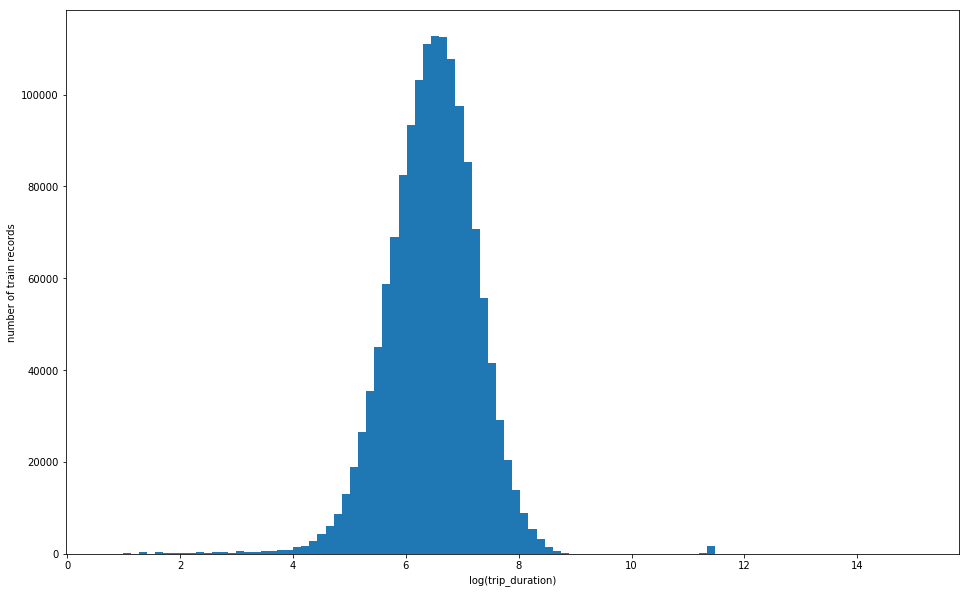

In [9]:
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

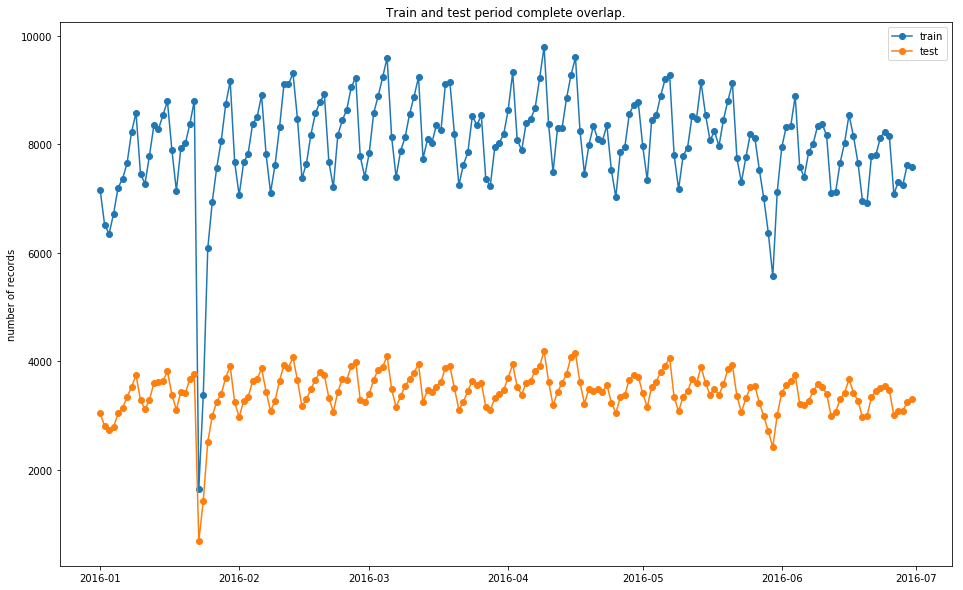

In [10]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

(40.5, 41)

(-74.5, -73.5)

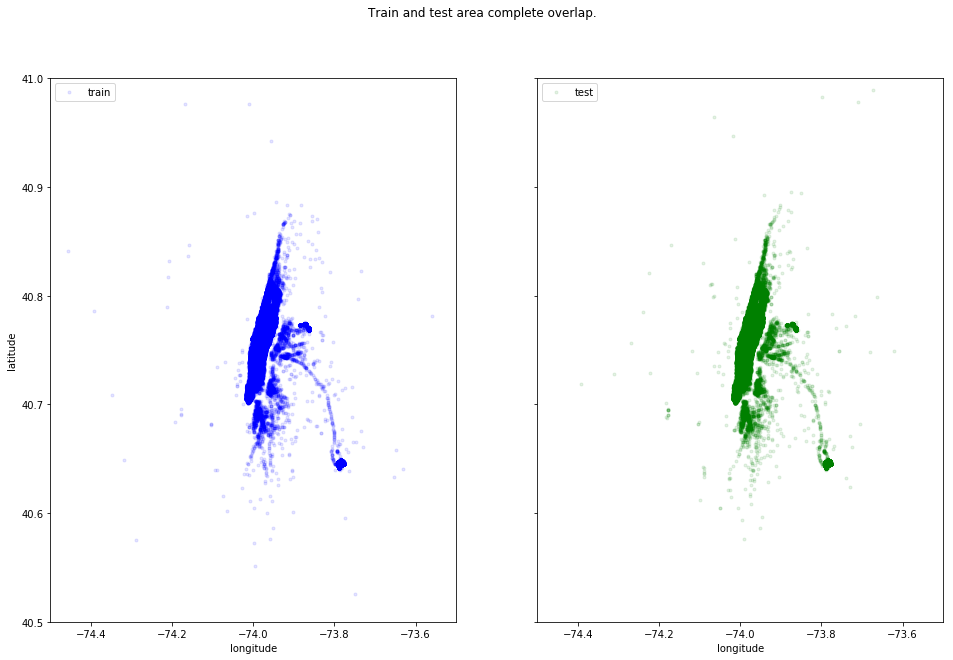

In [11]:
N = 100000
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].plot(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N], 'b.',
           label='train', alpha=0.1)
ax[1].plot(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N], 'g.',
           label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim([40.5, 41])
plt.xlim([-74.5, -73.5])
plt.show()

In [12]:
full = pd.concat([train, test])
coords = np.vstack((full[['pickup_latitude', 'pickup_longitude']], 
                   full[['dropoff_latitude', 'dropoff_longitude']]))
coords.shape

(4167556, 2)

In [13]:
pca = PCA().fit(coords)

In [14]:
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
train['pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

In [15]:
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [16]:
test.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'center_latitude',
       'center_longitude', 'pickup_date', 'pickup_weekday', 'pickup_day',
       'pickup_month', 'pickup_hour', 'pickup_minute', 'pickup_am',
       'night_trip', 'rush_hour', 'weekday', 'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1', 'pca_manhattan'],
      dtype='object')

In [17]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_haversine', 'distance_dummy_manhattan',
       'direction', 'center_latitude', 'center_longitude', 'pickup_date',
       'pickup_weekday', 'pickup_day', 'pickup_month', 'pickup_hour',
       'pickup_minute', 'pickup_am', 'night_trip', 'rush_hour', 'weekday',
       'log_trip_duration', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0',
       'dropoff_pca1', 'pca_manhattan'],
      dtype='object')

In [18]:
DO_NOT_USE_FOR_TRAINING = [
    'id', 'pickup_datetime', 'dropoff_datetime', 'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude','dropoff_latitude', 'trip_duration', 'pickup_date', 'log_trip_duration'
]

new_df = train.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in train], axis=1)
new_df_test = test.drop([col for col in DO_NOT_USE_FOR_TRAINING if col in test], axis=1)

new_df['store_and_fwd_flag'] = 1 *  new_df['store_and_fwd_flag'] == True
new_df_test['store_and_fwd_flag'] = 1 *  new_df['store_and_fwd_flag'] == True
new_df.shape, new_df_test.shape

((1458644, 22), (625134, 22))

In [19]:
new_df.columns == new_df_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [20]:
# Use log to handle outliers
y = np.log(train['trip_duration'].values)
train_attr = np.array(new_df)
train_attr.shape

(1458644, 22)

## Train

In [21]:
train_x, val_x, train_y, val_y = train_test_split(train_attr, y, test_size=0.2)

In [22]:
# Save some memory, if you have >=6G, just comment this out
del train, train_attr

In [23]:
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(val_x, label=val_y)
dtest = xgb.DMatrix(new_df_test.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [24]:
# Tune these params, see https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
xgb_pars = {'min_child_weight': 100, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 15,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model_xgb = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=20)

[0]	train-rmse:5.41956	valid-rmse:5.42076
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[20]	train-rmse:0.769139	valid-rmse:0.776458
[40]	train-rmse:0.378776	valid-rmse:0.402395
[60]	train-rmse:0.360651	valid-rmse:0.390072
[80]	train-rmse:0.355563	valid-rmse:0.388532
[100]	train-rmse:0.35227	valid-rmse:0.387532
[120]	train-rmse:0.350062	valid-rmse:0.387059
[140]	train-rmse:0.348457	valid-rmse:0.386915
[160]	train-rmse:0.346732	valid-rmse:0.386837
[180]	train-rmse:0.345286	valid-rmse:0.386871
[200]	train-rmse:0.343924	valid-rmse:0.386959
[220]	train-rmse:0.342491	valid-rmse:0.386809
[240]	train-rmse:0.34074	valid-rmse:0.386683
[260]	train-rmse:0.339667	valid-rmse:0.38669
[280]	train-rmse:0.338676	valid-rmse:0.386594
[300]	train-rmse:0.337142	valid-rmse:0.386435
[320]	train-rmse:0.336001	valid-rmse:0.386499
[340]	train-rmse:0.334703	valid-rmse:0.38636
[360]	train-rmse:0.333655	valid-rmse:0.

In [25]:
print('XGB Modeling RMSLE %.5f' % model_xgb.best_score)

XGB Modeling RMSLE 0.38626


In [26]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true), axis=-1))

In [27]:
TREE_REGRESSORS = [
    # These model are not tunned, default params in using
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

models = []
for regressor in TREE_REGRESSORS:
    clf = regressor
    clf = clf.fit(train_x, train_y)
    models.append(clf)

In [28]:
for model in models:
    # train_y is logged so rmse computes rmsle
    train_rmsle = rmse(train_y, model.predict(train_x))
    val_rmsle = rmse(val_y, model.predict(val_x))
    print('With model: {}\nTrain RMSLE: {}\nVal. RMSLE: {}'.format(model, train_rmsle, val_rmsle))

With model: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Train RMSLE: 8.868034339242484e-06
Val. RMSLE: 0.5767473693396291
With model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Train RMSLE: 0.17765651719981626
Val. RMSLE: 0.4203330971560295


In [29]:
test_attr = np.array(new_df_test)
model_rt, model_rf = models

In [30]:
pred_rt = model_rt.predict(test_attr)
pred_rt = np.exp(pred_rt)
pred_rt

array([ 1088.,   554.,   726., ...,  1213.,  2024.,  1997.])

In [31]:
submission = pd.concat([test['id'], pd.DataFrame(pred_rt, columns=['trip_duration'])], axis=1)
submission.to_csv('submission-rt.csv',index=False)

In [32]:
pred_rf = model_rf.predict(test_attr)
pred_rf = np.exp(pred_rf)
pred_rf

array([ 1018.7525421 ,   618.19113917,   694.463357  , ...,  1818.55406717,
        1728.48714294,  1522.32884487])

In [33]:
submission = pd.concat([test['id'], pd.DataFrame(pred_rf, columns=['trip_duration'])], axis=1)
submission.to_csv('submission-rf.csv',index=False)

In [34]:
pred_xgb = model_xgb.predict(dtest)
pred_xgb = np.exp(pred_xgb)
print('Test shape OK.') if test.shape[0] == pred_xgb.shape[0] else print('Oops')
pred_xgb

Test shape OK.


array([ 1142.12036133,   581.86590576,   605.13916016, ...,  2042.1295166 ,
        1834.28588867,  1692.21728516], dtype=float32)

In [35]:
submission = pd.concat([test['id'], pd.DataFrame(pred_xgb, columns=['trip_duration'])], axis=1)
submission.to_csv('submission-xgb.csv',index=False)